In [17]:
# import warnings
# warnings.simplefilter('ignore')
import sys
sys.path.append('/home1/jrudoler/src/')
import cmlreaders as cml
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['savefig.facecolor']='white'
import seaborn as sns
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
from pd_to_pb import pandas_to_pybeh as pb
import scipy as scp
plt.rcParams['axes.labelsize'] = 16
from classifier_io import ClassifierModel
from sklearn.linear_model import LogisticRegression
from sklearn import __version__ as sklearn_version
import pickle
from ptsa.data.filters import MorletWaveletFilter, ButterworthFilter
from ptsa.data.timeseries import TimeSeries
sns.set_palette('twilight')
import cmldask.CMLDask as da
from nicls_helpers import *
from compute_raw_event_features import compute_raw_event_features

subject_list = np.loadtxt("final_subject_list.txt", dtype=str)

We need to be cautious when matching the EEG epoch used during the experiment, since it's different than the interval used during training

In [3]:
settings = da.Settings()
settings['freqs'] = np.logspace(np.log10(6), np.log10(180), 8)
settings['width'] = 5
settings['buffer_time'] = int((1 / min(settings['freqs']) * settings['width'] / 2)*1000)
settings['rel_start'] = settings['buffer_time'] - 2000
settings['rel_stop'] =  -settings['buffer_time']
settings['experiment'] = 'NiclsCourierClosedLoop'
settings['clean'] = 0
settings['save'] = 1
settings['reference'] = 'average'
settings['save']("settings/phase2_settings_classifier.pkl")
settings

Settings(freqs=array([  6.        ,   9.75368156,  15.85571732,  25.77526961,
        41.90062864,  68.11423148, 110.72742057, 180.        ]), width=5, buffer_time=416, rel_start=-1584, rel_stop=-416, experiment='NiclsCourierClosedLoop', clean=0, save=1, reference='average')

In [18]:
events = pd.read_csv("processed_events_NiclsCourierClosedLoop.csv", index_col=0)

In [39]:
events.query("type=='WORD' and trial_type!='NoStim'")['probability'].isna().sum()

1508

In [30]:
client = da.new_dask_client_slurm("nicls_analysis",
                            "120GB",
                           log_directory='/home1/jrudoler/logs/')

Unique port for jrudoler is 51360
{'dashboard_address': ':51360'}
To view the dashboard, run: 
`ssh -fN jrudoler@rhino2.psych.upenn.edu -L 8000:192.168.86.144:51360` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [4]:
class_events = events.query("type == 'CLASSIFIER' and next_type=='WORD'")

In [34]:
settings_path = "settings/phase2_settings_classifier.pkl"
save_path = "/scratch/nicls_intermediate/closed_loop/classifier_powers/"
futures = []
for subject, evs in class_events.groupby("subject"):
    fut = client.submit(compute_raw_event_features, evs, subject, settings_path, save_path)
    futures.append(fut)

In [10]:
import statsmodels.formula.api as smf

In [31]:
full_data = []
performance_stats = pd.read_csv("system_performance_stats.csv", header=[0, 1], index_col=[0, 1])
for subject in subject_list:
    save_path = "/scratch/nicls_intermediate/closed_loop/classifier_powers/"
    try:
        ts = TimeSeries.from_hdf(save_path+subject+"_raw_feats.h5")
    except:
        print("hey!")
        continue
    perf = performance_stats.loc[subject]
    good_sessions = perf.index.values[~perf['bad_session'].values.ravel()]
    evs = events.query(
        "subject==@subject and session in @good_sessions"
    ).dropna(subset=["eegoffset", "probability"])
    ts = ts[np.isin(ts.session, good_sessions)]
    ts = ts.groupby('session').reduce(zscore, ddof=1, keep_attrs=True)     
    # ts = ts.groupby('session').apply(norm_sess_feats, n_lists=2)
    model = ClassifierModel(
        LogisticRegression(),
        sklearn_version=sklearn_version
    ).load_json(f"/data/eeg/scalp/ltp/NiclsCourierReadOnly/{subject}/nicls_{subject}_classifier.json").model
    probs = model.predict_proba(ts.data)[:, 1]
    evs = evs.query("type=='CLASSIFIER' and next_type=='WORD'")
    evs["ideal_proba"] = probs
    full_data.append(evs)

full_data = pd.concat(full_data)
full_data["matched_predictions"] = np.sign(full_data['probability']-0.5)==np.sign(full_data['ideal_proba']-0.5)
full_data.to_csv("classifier_events_with_matched_predictions.csv")

In [22]:
memodel = smf.mixedlm("recalled ~ probability + probability:ideal_proba",
                      full_data.query("trial_type=='Pos'"),
                      groups=full_data.query("trial_type=='Pos'")["subject"])
fit = memodel.fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    recalled  
No. Observations:     1915       Method:                REML      
No. Groups:           21         Scale:                 0.1948    
Min. group size:      10         Log-Likelihood:        -1178.0377
Max. group size:      179        Converged:             Yes       
Mean group size:      91.2                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.751    0.063 11.944 0.000  0.628  0.875
probability             -0.222    0.107 -2.085 0.037 -0.431 -0.013
probability:ideal_proba  0.222    0.073  3.031 0.002  0.078  0.365
Group Var                0.019    0.016                           
==================================================================

"""

In [15]:
np.isclose(probs, 
           evs.query("type=='CLASSIFIER' and next_type=='WORD'")['probability'].values,
           atol=.05)

array([False, False, False, False, False, False,  True, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True, False, False, False, False, False,  True, False,
        True, False, False, False,  True, False,  True,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True, False, False,
        True, False,  True, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
        True, False, False,  True, False,  True, False,  True,  True,
       False, False,  True, False,  True, False, False, False, False,
       False, False,

## Memory Improvement

In [6]:
with open(f"loso_results_read_only.pkl", "rb") as f:
    result_dict = pickle.load(f)
with open(f"clf_results_closed_loop.pkl", "rb") as f:
    cl_result_dict = pickle.load(f)
    
avg = full_data.groupby(
    ['subject', 'session']
).agg(
    {'recalled':'mean'}
).mean(level=0)

above_med = avg >= avg.median()

avg = avg.reset_index()
avg['RO_auc'] = avg['subject'].apply(lambda k: result_dict[k][2])
avg['CL_auc'] = avg['subject'].apply(lambda k: cl_result_dict[k][2])
avg.set_index('subject')

full_data['above_avg'] = np.isin(full_data['subject'].values, above_med.index[above_med['recalled']])
plot_data = full_data.query("trial_type!='NoStim'").groupby(['subject', 'trial_type', 'session']).agg('mean').reset_index()\
            .groupby(['subject', 'trial_type']).agg({"recalled":'mean', "session":"count"})
matched_plot_data = full_data.query("trial_type!='NoStim' and matched_predictions").groupby(['subject', 'trial_type', 'session']).agg('mean').reset_index()\
            .groupby(['subject', 'trial_type']).agg({"recalled":'mean', "session":"count"})
avg["positive"] = plot_data.xs('Pos', level=1)['recalled'].values
avg["negative"] = plot_data.xs('Neg', level=1)['recalled'].values
avg["sham"] = plot_data.xs('Sham', level=1)['recalled'].values
avg["pct_change"] = 100*(plot_data.xs('Pos', level=1)['recalled'] - plot_data.xs('Neg', level=1)['recalled']).values / plot_data.xs('Neg', level=1)['recalled'].values
avg["matched_pct_change"] = 100*(matched_plot_data.xs('Pos', level=1)['recalled'] - matched_plot_data.xs('Neg', level=1)['recalled']).values / matched_plot_data.xs('Neg', level=1)['recalled'].values

df = full_data.query("matched_predictions").groupby(["subject", "trial_type", "recalled"]).agg({"item":"count"}).reset_index()
df = df.pivot(index=["subject", "trial_type"], columns="recalled", values="item")
df.fillna(0, inplace=True)

p_dict = {}
for idx, frame in df.reset_index().groupby("subject"):
    frame = frame.query("trial_type in ['Pos', 'Neg']")
#     chi2, p, _, _= scp.stats.chi2_contingency(frame[[0, 1]].values)
    chi2, p = scp.stats.fisher_exact(frame[[1, 0]].values)
#     print(frame[[1, 0]].values)
#     print(chi2, p)
    p_dict[idx] = p

avg['p'] = avg['subject'].map(p_dict)
avg['sig'] = avg['p'] <= .05

good_class_subs = [k for k in cl_result_dict if np.mean(cl_result_dict[k][3]>cl_result_dict[k][2])<.05]
good_class_mask = np.isin(avg["subject"], good_class_subs)
good_class_subs
avg['good_class'] = good_class_mask

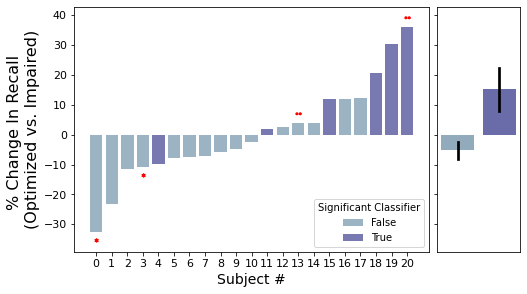

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
avg_sorted = avg.sort_values("pct_change").reset_index()
fig = plt.figure(figsize=(8, 4.5))
gs = fig.add_gridspec(1, 10)
ax = fig.add_subplot(gs[0:8])
# sns.barplot(data=avg_sorted, ax = ax, x="subject", y="matched_pct_change", 
#             facecolor=(0, 0, 0, 0), alpha=None, errcolor='none', dodge=False, edgecolor =(1,0,0,0.4))
sns.barplot(data=avg_sorted, ax=ax, alpha=.9,
            x="subject", y="pct_change", hue="good_class", dodge=False, zorder=0)
plt.xticks(ticks=np.arange(len(avg_sorted)), labels=np.arange(len(avg_sorted)))
sns.move_legend(ax, 0, title="Significant Classifier")
avg_ax = fig.add_subplot(gs[8:10])
avg_ax.sharey(ax)
sns.barplot(data=avg_sorted, ax = avg_ax, x="good_class", y="pct_change", hue="good_class", errcolor='black', ci=68, dodge=False)
# sns.barplot(data=avg_sorted, ax=avg_ax,
#             x="good_class", y="matched_pct_change", facecolor=(0, 0, 0, 0), alpha=None, errcolor='none', dodge=False, edgecolor =(1,0,0,0.4))
avg_ax.legend_.remove()
avg_ax.set_xticks([])
avg_ax.set_xlabel("")
ax.tick_params(labelsize=11)
avg_ax.tick_params(labelleft=False, labelsize=12, labelrotation=60)
avg_ax.set_ylabel("")
ax.set_xlabel("Subject #", fontsize=14)
ax.set_ylabel("% Change In Recall \n(Optimized vs. Impaired)")
mask05 = avg_sorted['p'] <= 0.05
mask1 = (avg_sorted['p'] <= 0.1)&(avg_sorted['p'] > 0.05)
ax.scatter(np.arange(len(avg))[mask05], avg_sorted["pct_change"][mask05]+np.sign(avg_sorted["pct_change"])[mask05]*3, marker='$**$', c='r', s=30)
ax.scatter(np.arange(len(avg))[mask1], avg_sorted["pct_change"][mask1]+np.sign(avg_sorted["pct_change"])[mask1]*3, marker='$*$', c='r', s=30)
# plt.savefig("FinalReport/sorted_pct_change.png", dpi=300, bbox_inches="tight")

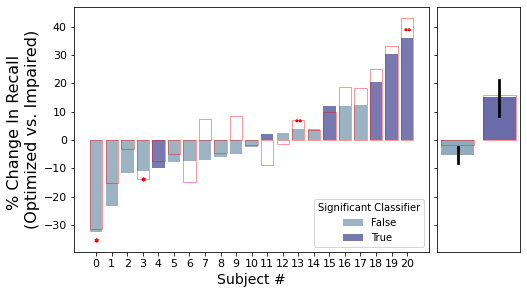

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.facecolor']='white'
avg_sorted = avg.sort_values("pct_change").reset_index()
fig = plt.figure(figsize=(8, 4.5))
gs = fig.add_gridspec(1, 10)
ax = fig.add_subplot(gs[0:8])
sns.barplot(data=avg_sorted, ax = ax, x="subject", y="matched_pct_change", 
            facecolor=(0, 0, 0, 0), alpha=None, errcolor='none', dodge=False, edgecolor =(1,0,0,0.4))
sns.barplot(data=avg_sorted, ax=ax, alpha=.9,
            x="subject", y="pct_change", hue="good_class", dodge=False, zorder=0)
plt.xticks(ticks=np.arange(len(avg_sorted)), labels=np.arange(len(avg_sorted)))
sns.move_legend(ax, 0, title="Significant Classifier")
avg_ax = fig.add_subplot(gs[8:10])
avg_ax.sharey(ax)
sns.barplot(data=avg_sorted, ax = avg_ax, x="good_class", y="pct_change", hue="good_class", errcolor='black', ci=68, dodge=False)
sns.barplot(data=avg_sorted, ax=avg_ax,
            x="good_class", y="matched_pct_change", facecolor=(0, 0, 0, 0), alpha=None, errcolor='none', dodge=False, edgecolor =(1,0,0,0.4))
avg_ax.legend_.remove()
avg_ax.set_xticks([])
avg_ax.set_xlabel("")
ax.tick_params(labelsize=11)
avg_ax.tick_params(labelleft=False, labelsize=12, labelrotation=60)
avg_ax.set_ylabel("")
ax.set_xlabel("Subject #", fontsize=14)
ax.set_ylabel("% Change In Recall \n(Optimized vs. Impaired)")
mask05 = avg_sorted['p'] <= 0.05
mask1 = (avg_sorted['p'] <= 0.1)&(avg_sorted['p'] > 0.05)
ax.scatter(np.arange(len(avg))[mask05], avg_sorted["pct_change"][mask05]+np.sign(avg_sorted["pct_change"])[mask05]*3, marker='$**$', c='r', s=30)
ax.scatter(np.arange(len(avg))[mask1], avg_sorted["pct_change"][mask1]+np.sign(avg_sorted["pct_change"])[mask1]*3, marker='$*$', c='r', s=30)
plt.savefig("FinalReport/sorted_pct_change_matched.pdf", dpi=300, bbox_inches="tight")

In [12]:
scp.stats.pearsonr(avg_sorted["CL_auc"], avg_sorted["matched_pct_change"])

PearsonRResult(statistic=0.36176336345372606, pvalue=0.10708782918807051)

## TODO: Need to reconstruct the normalization epochs....
They're not associated with any unity events... just use another event from the same session as an anchor to compute eegoffset?

## Classifiers

In [183]:
perf = pd.read_csv("read_only_AUC_comparisons.csv", index_col=0)

In [ ]:
from scipy.stats import tt

In [184]:
perf['AUC']

,subject,AUC,clean_AUC,bipolar_AUC
0,LTP462,0.550459,0.579953,0.562681
1,LTP468,0.485519,0.513268,0.503563
2,LTP470,0.575867,0.580269,0.564429
3,LTP473,0.522095,0.504571,0.534254
4,LTP474,0.541850,0.522784,0.518758
5,LTP475,0.589504,0.514104,0.585079
6,LTP476,0.585922,0.560292,0.556999
7,LTP477,0.619852,0.610168,0.607196
8,LTP478,0.508076,0.516409,0.533869
9,LTP479,0.611040,0.594886,0.582892
